# Importação das bibliotecas

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Verificação da disponibilidade da GPU

In [10]:
# Verifica a disponibilidade da GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Arquitetura do modelo

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Primeira camada convolucional com 32 filtros de tamanho 5x5, operando 
        # em uma imagem com 3 canais de entrada.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=5)
        
        # Primeira camada totalmente conectada com 256 neurônios. A entrada 
        # é achatada em um vetor de tamanho 128 * 10 * 10 -> pixel(filtro) * 
        # altura * largura
        self.fc1 = nn.Linear(128 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
        
        # Uma camada de dropout é definida aqui com uma taxa de 0.5. O dropout 
        # ajuda a regularizar a rede, desativando aleatoriamente alguns neurônios 
        # durante o treinamento para evitar o overfitting.
        self.dropout = nn.Dropout(0.5)
    
        # Adiciona uma camada de normalização em lote (batch normalization) após 
        # a primeira camada convolucional. Isso ajuda a regularizar o treinamento, 
        # tornando-o mais estável e permitindo que as camadas subsequentes recebam 
        # entradas mais consistentes.
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm2d(128)

    # verbose=False, é usado para controlar a saída de informações adicionais durante 
    # o processo de passagem direta (forward pass) da rede neural.
    def forward(self, x, verbose=False):
        # Após a convolução inicial, os valores de ativação passam pela camada de 
        # normalização em lote antes da função de ativação ReLU. Isso ajuda a 
        # controlar a distribuição dos valores de ativação ao longo do treinamento, 
        # o que pode levar a um treinamento mais rápido e estável da rede.
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 128*10*10)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

# Carregamento do modelo treinado e transformações para o conjunto de teste

In [12]:
# Carrega o modelo treinado
model = Net().to(device)
model.load_state_dict(torch.load('/kaggle/input/pesos-treinado/model_fold12_epoch18.pth'))
model.eval()  # Coloca o modelo no modo de avaliação

# Cria transformações para o conjunto de teste
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Lista os arquivos de teste
# Lista os arquivos de imagem de teste no diretório
test_root = '/kaggle/input/cats-dogs/dogsandcats/test1'
test_files = [os.path.join(test_root, file) for file in os.listdir(test_root) if file != 'test1']

# Definição da classe do conjunto de teste

In [13]:
# Define a classe do conjunto de teste
# Esta classe herda da classe Dataset da biblioteca PyTorch, 
# o que indica que ela deve ser usada como base para criar um 
# conjunto de dados personalizado.
class TestCatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')  # Faz uma conversão para RGB
        image = self.transform(image)  # Aplica a transformação
        fileid = os.path.splitext(os.path.basename(image_path))[0]
        # Extrai o ID do arquivo a partir do caminho do arquivo, removendo a extensão do arquivo e o caminho.
        return image, fileid

# Criação do conjunto de teste e DataLoader

In [14]:
# Cria o conjunto de teste e o DataLoader
test_dataset = TestCatDogDataset(test_files, test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=6, shuffle=False)

# Função de teste

In [15]:
# Função para realizar a inferência no conjunto de teste e retornar as probabilidades
def test(model, test_loader):
    probabilities = []  # Lista para armazenar as probabilidades de saída
    with torch.no_grad():  # Desativa o cálculo de gradientes durante a inferência
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)  # Faz a inferência real com os dados de entrada
            probabilities.extend(F.softmax(output, dim=1).cpu().numpy())
            # Calcula  as probabilidades de saída a partir do tensor de saída 'output'.
    return probabilities

# Visualização das previsões

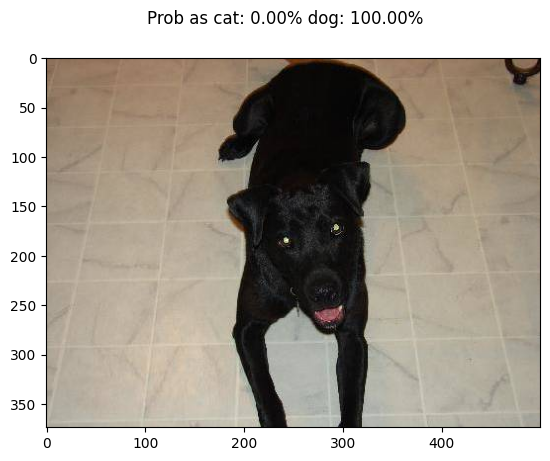

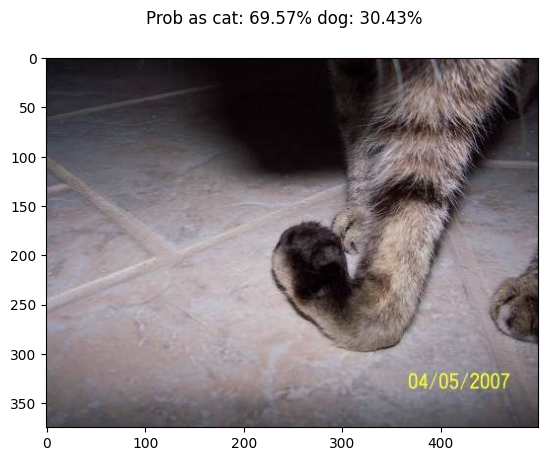

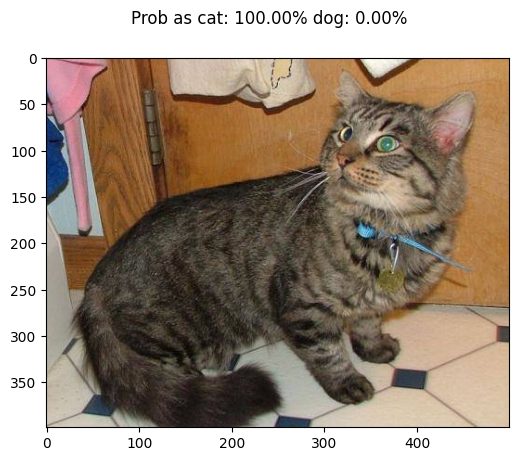

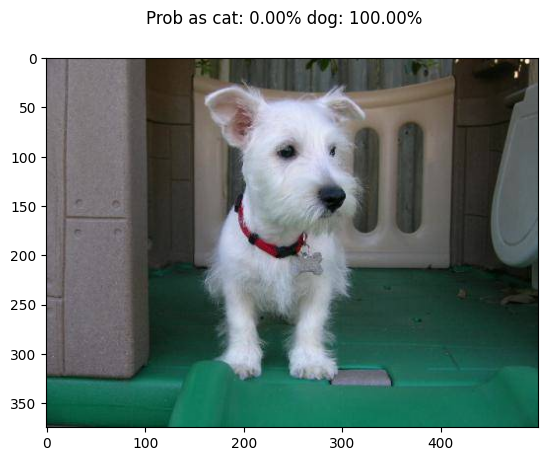

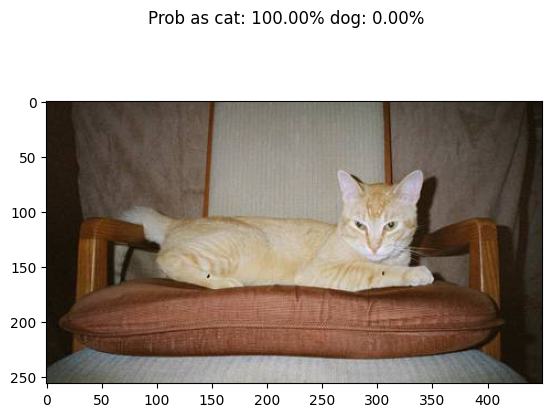

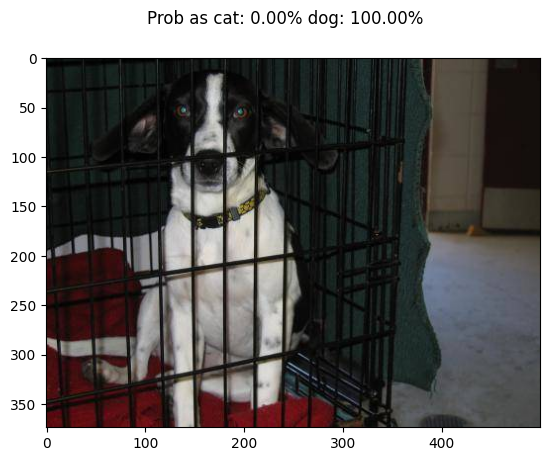

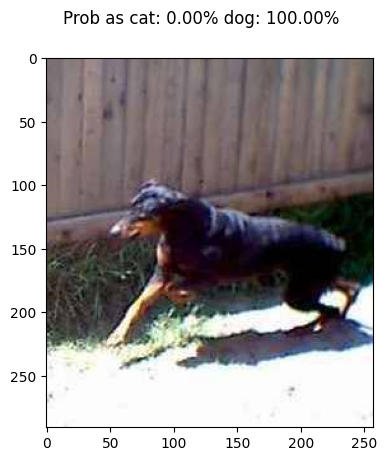

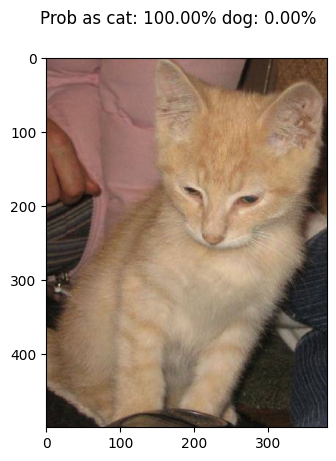

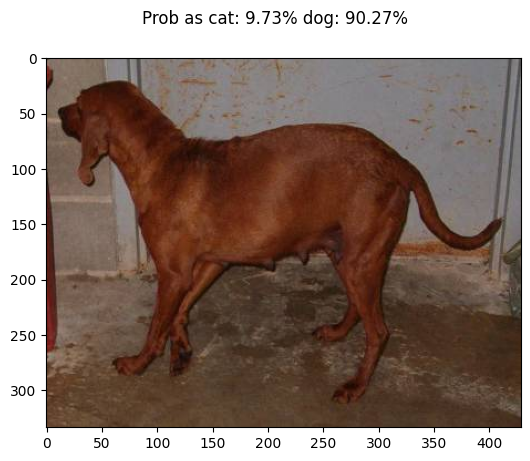

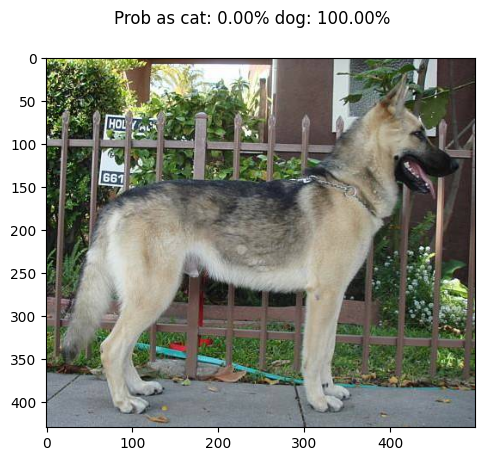

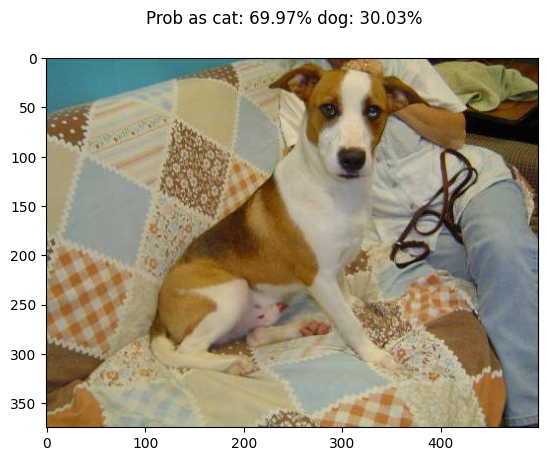

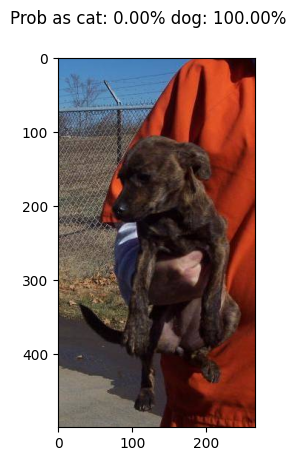

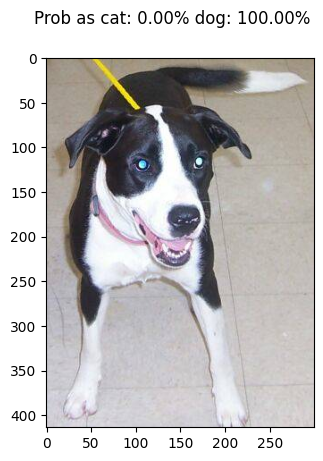

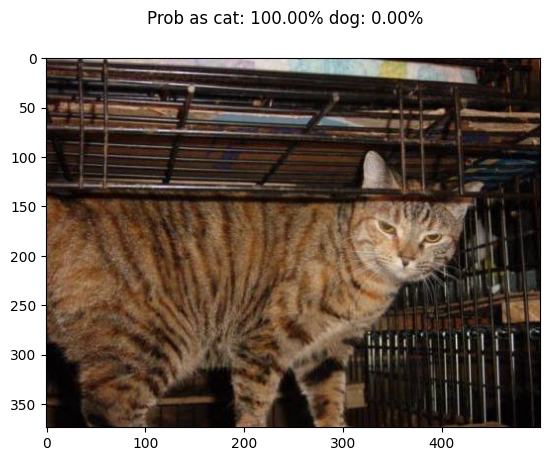

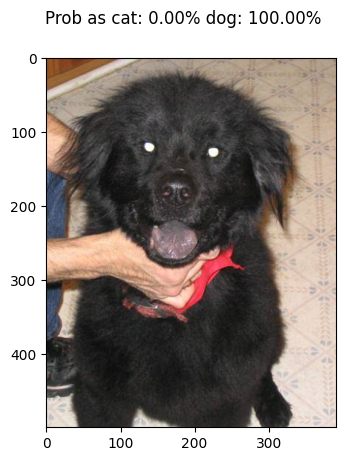

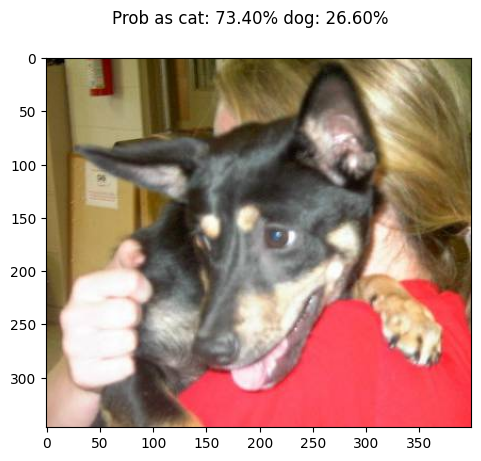

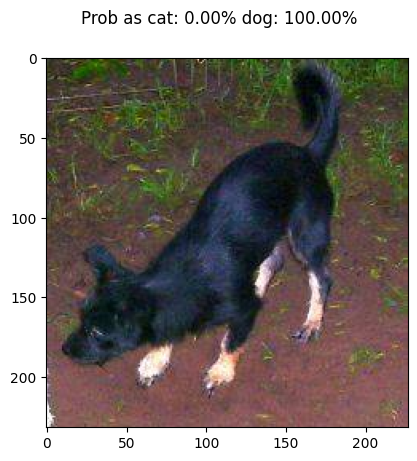

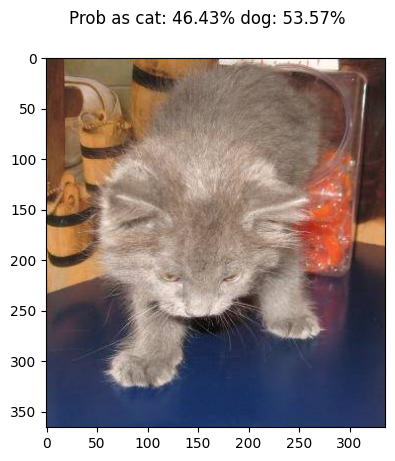

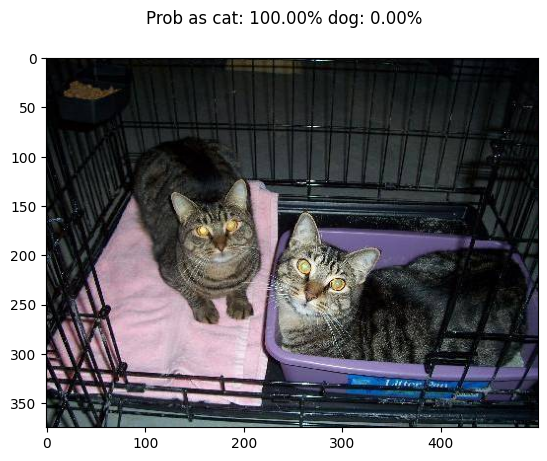

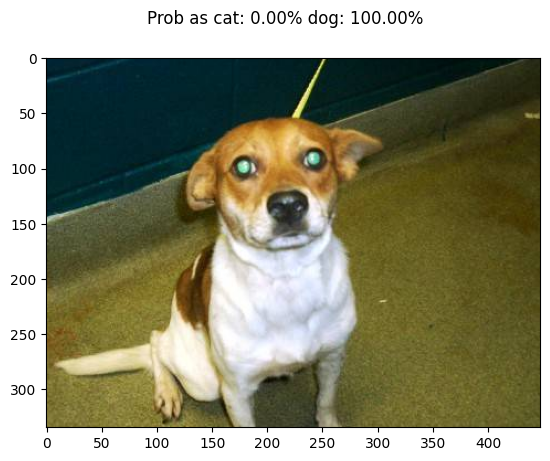

In [16]:
# Execute a inferência no conjunto de teste
probabilities = test(model, test_loader)

# Imprime as previsões e imagens
for img_path, prob in zip(test_files[:20], probabilities[:20]):
    pil_img = Image.open(img_path, 'r')
    probability_for_cat = prob[0]
    probability_for_dog = prob[1]
    title = f"Prob as cat: {probability_for_cat:.2%} dog: {probability_for_dog:.2%}"
    plt.figure()
    plt.imshow(pil_img)
    plt.suptitle(title)
    plt.show()